# ENTSO-E Price Analysis

This repository contains Python code to fetch, process, and analyze **hourly electricity prices** from the ENTSO-E API (Document Type A44). It includes calculation of statistical measures, VaR/CVaR, and sensitivity analysis.

## Features

- Fetch hourly prices from ENTSO-E for a full year.
- Clean and transform data into a time series DataFrame (`ndf`).
- Compute basic statistics: mean, variance, standard deviation.
- Plot hourly price histograms.
- Calculate **Value at Risk (VaR)** and **Conditional Value at Risk (CVaR)** for each hour.
- Perform **sensitivity analysis** over multiple confidence levels (0–60%).
- Visualize VaR and CVaR curves for all 24 hours.

## Requirements

- Python 3.x
- Libraries: `pandas`, `numpy`, `matplotlib`, `requests`

Install dependencies via:

```bash
pip install pandas numpy matplotlib requests


# Usage

- Set your ENTSO-E API key in the script:

   API_KEY = "YOUR_API_KEY_HERE"


- Run the script to fetch and process data:

  python enstoe_analysis.py


- Explore the results in ndf or plot VaR/CVaR for any hour.

# Notes

- Ensure your API key has sufficient permissions for large data requests.

- Adjust the confidence level alpha for VaR/CVaR as needed.

- Plotting can be customized for individual hours or all 24 hours.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from xml.etree import ElementTree as ET

In [ ]:
!pip install xmltodict

In [1]:
API_KEY = "your-key"

In [ ]:
def strip_ns(tag):
    return tag.split('}')[-1] if '}' in tag else tag

def fetch_month(start, end):
    url = "https://web-api.tp.entsoe.eu/api"
    params = {
        "securityToken": API_KEY,
        "documentType": "A44",
        "in_Domain": "10YNL----------L",
        "out_Domain": "10YNL----------L",
        "periodStart": start,
        "periodEnd": end
    }
    response = requests.get(url, params=params)
    if response.status_code != 200:
        return pd.DataFrame()

    root = ET.fromstring(response.content)
    rows = []

    for timeseries in root.iter():
        if strip_ns(timeseries.tag) == 'TimeSeries':
            for period in timeseries.iter():
                if strip_ns(period.tag) == 'Period':
                    start_elem = period.find('.//{*}start')
                    end_elem = period.find('.//{*}end')
                    start_dt = pd.to_datetime(start_elem.text) if start_elem is not None else None
                    end_dt = pd.to_datetime(end_elem.text) if end_elem is not None else None

                    for point in period.iter():
                        if strip_ns(point.tag) == 'Point':
                            position_elem = point.find('.//{*}position')
                            price_elem = point.find('.//{*}price.amount')
                            if position_elem is not None and price_elem is not None:
                                pos = int(position_elem.text)
                                price = float(price_elem.text)
                                timestamp = start_dt + pd.to_timedelta(pos - 1, unit='h')
                                rows.append({
                                    "timestamp": timestamp,
                                    "price": price,
                                    "position": pos,
                                    "period_start": start_dt,
                                    "period_end": end_dt
                                })
    return pd.DataFrame(rows)

dfs = []
for month in range(1, 13):
    start = f"2023{month:02d}010000"
    end = f"2023{month+1:02d}010000" if month != 12 else "202312302300"
    df_month = fetch_month(start, end)
    dfs.append(df_month)

df_full = pd.concat(dfs, ignore_index=True)
df_full = df_full.sort_values("timestamp").reset_index(drop=True)

print(df_full.info())
print(df_full.head(100000))
print(df_full.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8953 entries, 0 to 8952
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   timestamp     8953 non-null   datetime64[ns, UTC]
 1   price         8953 non-null   float64            
 2   position      8953 non-null   int64              
 3   period_start  8953 non-null   datetime64[ns, UTC]
 4   period_end    8953 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](3), float64(1), int64(1)
memory usage: 349.9 KB
None
                     timestamp  price  position              period_start  \
0    2022-12-31 23:00:00+00:00  -3.61         1 2022-12-31 23:00:00+00:00   
1    2023-01-01 00:00:00+00:00  -1.46         2 2022-12-31 23:00:00+00:00   
2    2023-01-01 01:00:00+00:00  -1.52         3 2022-12-31 23:00:00+00:00   
3    2023-01-01 02:00:00+00:00  -5.00         4 2022-12-31 23:00:00+00:00   
4    2023-01-01 03:00:00+00:00  -4.60      

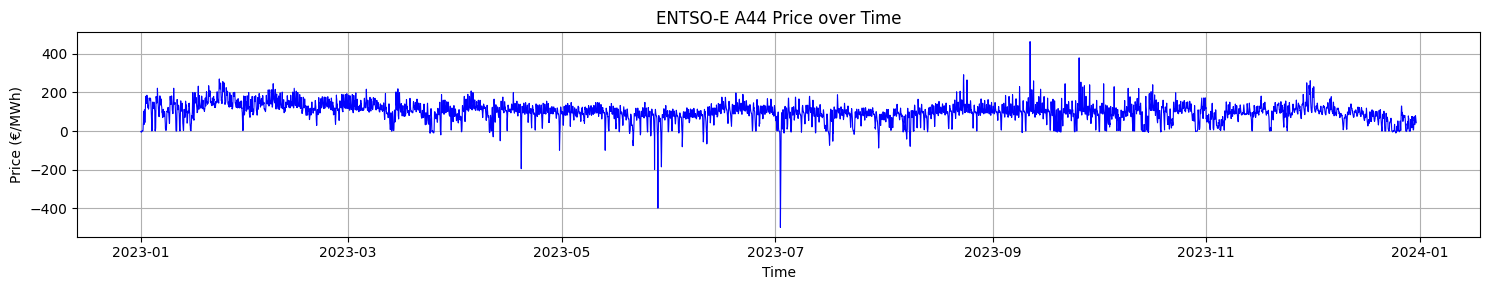

In [ ]:
import matplotlib.pyplot as plt

# Make sure timestamp is datetime
df_full['timestamp'] = pd.to_datetime(df_full['timestamp'])

# Plot
plt.figure(figsize=(15, 3))
plt.plot(df_full['timestamp'], df_full['price'], color='blue', linewidth=0.8)
plt.xlabel('Time')
plt.ylabel('Price (€/MWh)')
plt.title('ENTSO-E A44 Price over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Select only timestamp and price
ndf = df_full[['timestamp', 'price']].copy()

# Optional: set timestamp as the index (useful for time series)
ndf.set_index('timestamp', inplace=True)

print(ndf.head())

                           price
timestamp                       
2022-12-31 23:00:00+00:00  -3.61
2023-01-01 00:00:00+00:00  -1.46
2023-01-01 01:00:00+00:00  -1.52
2023-01-01 02:00:00+00:00  -5.00
2023-01-01 03:00:00+00:00  -4.60


Hour 20:00 statistics:
Mean: 112.10
Variance: 806.95
Standard Deviation: 28.41


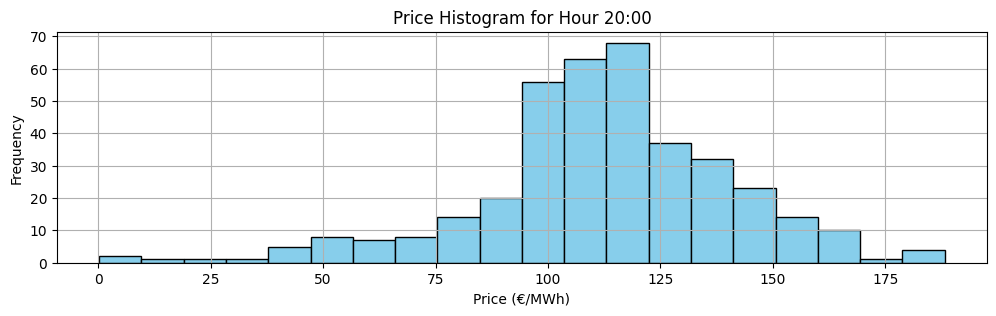

In [ ]:
import matplotlib.pyplot as plt

# Make sure timestamp is datetime and add hour column
ndf['hour'] = ndf.index.hour  # extracts the hour from timestamp

# -------------------------------
# Choose which hour to plot
# -------------------------------
hour_to_plot = 20  # 0-23, e.g., 15 = 3 PM

# Filter data for the chosen hour
hour_data = ndf[ndf['hour'] == hour_to_plot]['price']

# Calculate statistics
mean_price = hour_data.mean()
variance_price = hour_data.var()
std_price = hour_data.std()

# Print statistics
print(f"Hour {hour_to_plot}:00 statistics:")
print(f"Mean: {mean_price:.2f}")
print(f"Variance: {variance_price:.2f}")
print(f"Standard Deviation: {std_price:.2f}")

# Plot histogram
plt.figure(figsize=(12,3))
plt.hist(hour_data, bins=20, color='skyblue', edgecolor='black')
plt.title(f'Price Histogram for Hour {hour_to_plot}:00')
plt.xlabel('Price (€/MWh)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Make sure 'hour' column exists
ndf['hour'] = ndf.index.hour

# Confidence level for VaR/CVaR
alpha = 0.05  # 5% tail

# Prepare a DataFrame to store hourly results
risk_df = pd.DataFrame(columns=['hour', 'VaR', 'CVaR'])

# Loop through each hour
for h in range(24):
    prices = ndf[ndf['hour'] == h]['price']
    if len(prices) == 0:
        continue

    # VaR: percentile at alpha
    var = np.percentile(prices, 100 * alpha)

    # CVaR: mean of losses beyond VaR
    cvar = prices[prices <= var].mean()

    risk_df = pd.concat([risk_df, pd.DataFrame({'hour':[h], 'VaR':[var], 'CVaR':[cvar]})], ignore_index=True)

# Show results
risk_df


/tmp/ipython-input-956108635.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  risk_df = pd.concat([risk_df, pd.DataFrame({'hour':[h], 'VaR':[var], 'CVaR':[cvar]})], ignore_index=True)


,hour,VaR,CVaR
0,0,2.0025,-0.561579
1,1,0.2180,-1.026842
2,2,0.0195,-1.695263
3,3,0.9725,-1.626842
4,4,5.2060,-0.470526
5,5,20.7670,1.082105
6,6,29.4060,5.917895
7,7,25.5935,6.598947
8,8,4.9060,-4.752105
9,9,-0.0390,-25.800526


In [ ]:
import numpy as np
import pandas as pd

# Make sure 'hour' column exists
ndf['hour'] = ndf.index.hour

# Confidence levels from 0% to 60% in steps of 5%
alphas = np.arange(0, 0.61, 0.05)  # 0, 0.05, ..., 0.6

# Prepare a DataFrame to store results
sensitivity_df = pd.DataFrame(columns=['hour', 'alpha', 'VaR', 'CVaR'])

# Loop through each hour
for h in range(24):
    prices = ndf[ndf['hour'] == h]['price']
    if len(prices) == 0:
        continue

    for alpha in alphas:
        # VaR: percentile at alpha
        var = np.percentile(prices, 100 * alpha)

        # CVaR: mean of prices below VaR
        cvar = prices[prices <= var].mean()

        sensitivity_df = pd.concat([
            sensitivity_df,
            pd.DataFrame({'hour':[h], 'alpha':[alpha], 'VaR':[var], 'CVaR':[cvar]})
        ], ignore_index=True)

# Display a sample
sensitivity_df.head(20)


/tmp/ipython-input-497669233.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sensitivity_df = pd.concat([


,hour,alpha,VaR,CVaR
0,0,0.00,-4.4000,-4.400000
1,0,0.05,2.0025,-0.561579
2,0,0.10,20.4940,4.185000
3,0,0.15,50.3120,14.450000
4,0,0.20,65.0020,25.373067
5,0,0.25,70.4425,33.736237
6,0,0.30,77.7480,40.616786
7,0,0.35,80.1985,45.933615
8,0,0.40,83.6840,50.574362
9,0,0.45,86.9720,54.308144


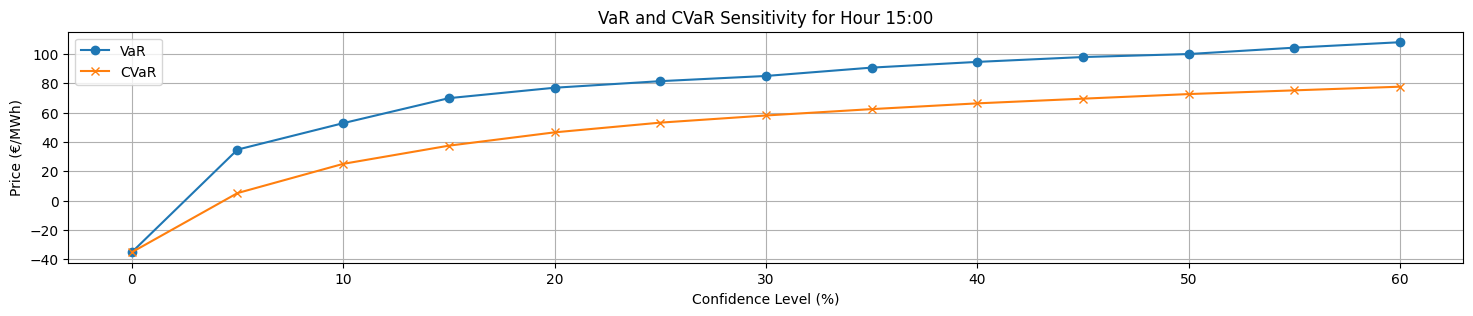

In [ ]:
import matplotlib.pyplot as plt

# Example: plot for a specific hour
hour_to_plot = 15  # choose which hour (0-23)

# Filter data for this hour
hour_data = sensitivity_df[sensitivity_df['hour'] == hour_to_plot]

plt.figure(figsize=(18,3))
plt.plot(hour_data['alpha']*100, hour_data['VaR'], label='VaR', marker='o')
plt.plot(hour_data['alpha']*100, hour_data['CVaR'], label='CVaR', marker='x')
plt.xlabel('Confidence Level (%)')
plt.ylabel('Price (€/MWh)')
plt.title(f'VaR and CVaR Sensitivity for Hour {hour_to_plot}:00')
plt.grid(True)
plt.legend()
plt.show()


/tmp/ipython-input-2703889387.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


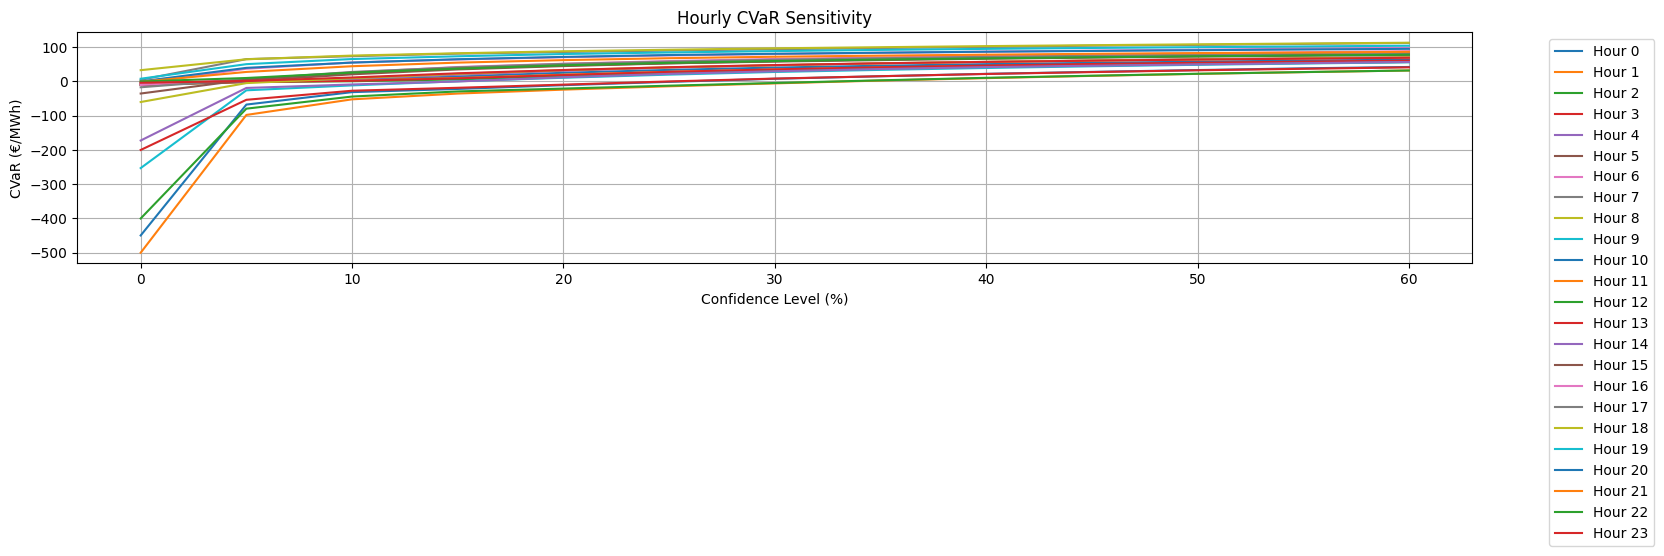

In [ ]:
plt.figure(figsize=(18,3))
for h in range(24):
    hour_data = sensitivity_df[sensitivity_df['hour'] == h]
    plt.plot(hour_data['alpha']*100, hour_data['CVaR'], label=f'Hour {h}')

plt.xlabel('Confidence Level (%)')
plt.ylabel('CVaR (€/MWh)')
plt.title('Hourly CVaR Sensitivity')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


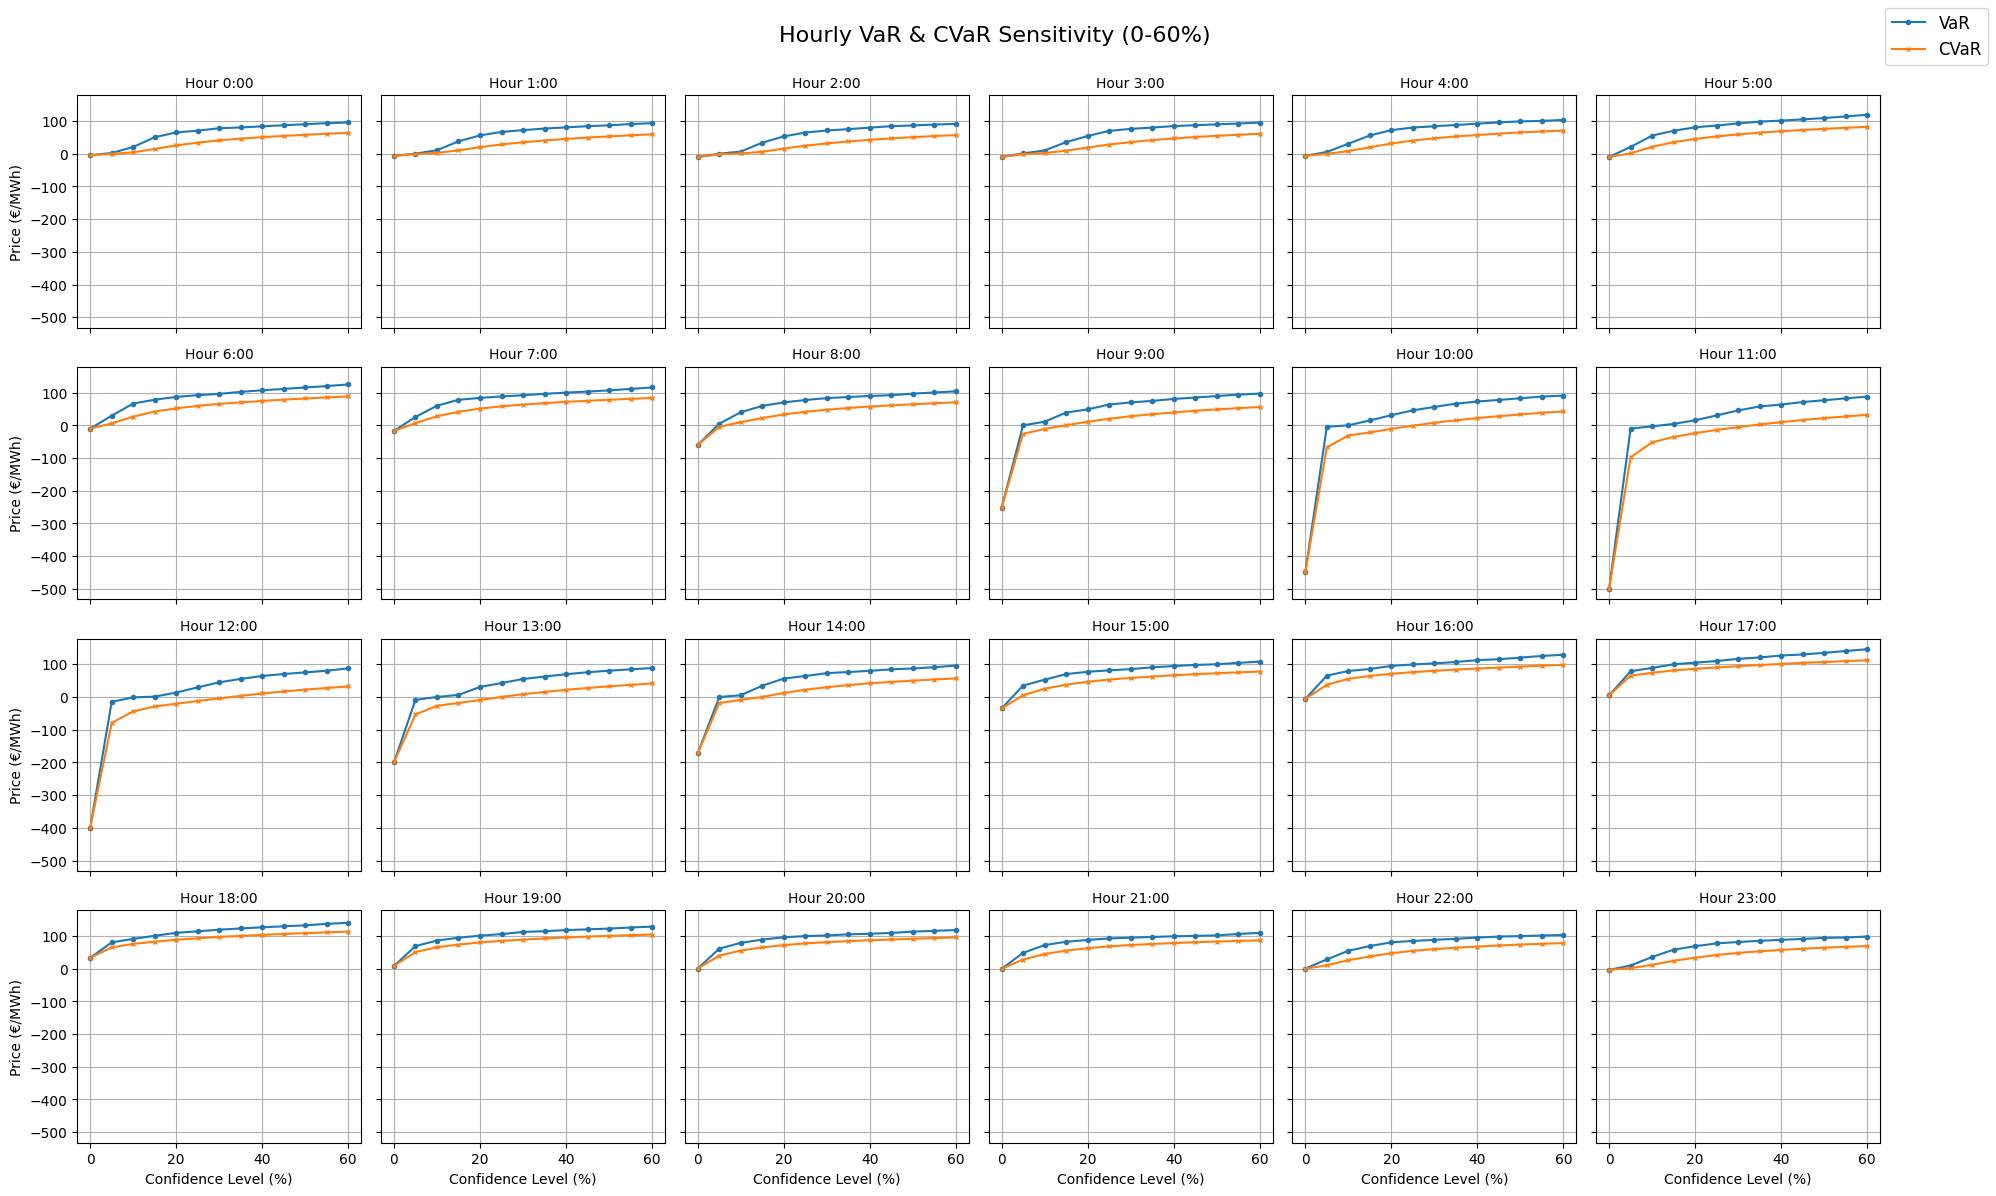

In [ ]:
import matplotlib.pyplot as plt

# Create 4x6 subplots for 24 hours
fig, axes = plt.subplots(4, 6, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()  # flatten 2D array for easy iteration

for h in range(24):
    ax = axes[h]
    hour_data = sensitivity_df[sensitivity_df['hour'] == h]

    ax.plot(hour_data['alpha']*100, hour_data['VaR'], label='VaR', marker='o', markersize=3)
    ax.plot(hour_data['alpha']*100, hour_data['CVaR'], label='CVaR', marker='x', markersize=3)
    ax.set_title(f'Hour {h}:00', fontsize=10)
    ax.grid(True)
    if h % 6 == 0:
        ax.set_ylabel('Price (€/MWh)')
    if h >= 18:  # bottom row
        ax.set_xlabel('Confidence Level (%)')

# Common legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=12)

plt.tight_layout(rect=[0,0,0.95,0.95])  # leave space for legend
plt.suptitle('Hourly VaR & CVaR Sensitivity (0-60%)', fontsize=16)
plt.show()
